# Digital Advertising Posts Insights Data


### Overview
This is a post dataset which contains 59 posts occurring between 2018-01-12 and 2020-10-28 for a marketing agency. The company mainly does digital advertising. Many customers of the company are small-to-middle promising brands.

# LIBRARY

In [1]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import glob
from pathlib import Path
import xml.etree.ElementTree as ET

# LOAD DATA

In [2]:
pattern = '../input/gopopcorn/*.xls'
excel_files = glob.glob(pattern)

# Cleaning excel_files
for i in range (len(excel_files)):
    excel_files[i] = excel_files[i][2:]
excel_files

['/input/gopopcorn/Facebook Insights Data Export (Post Level) - Popcorn - 2020-10-28 (5).xls',
 '/input/gopopcorn/Facebook Insights Data Export (Post Level) - Popcorn - 2020-10-28 (2).xls',
 '/input/gopopcorn/Facebook Insights Data Export (Post Level) - Popcorn - 2020-10-28 (6).xls',
 '/input/gopopcorn/Facebook Insights Data Export (Post Level) - Popcorn - 2020-10-28 (1).xls',
 '/input/gopopcorn/Facebook Insights Data Export (Post Level) - Popcorn - 2020-10-28 (3).xls',
 '/input/gopopcorn/Facebook Insights Data Export (Post Level) - Popcorn - 2020-10-28 (7).xls',
 '/input/gopopcorn/Facebook Insights Data Export (Post Level) - Popcorn - 2020-10-28 (4).xls',
 '/input/gopopcorn/Facebook Insights Data Export (Post Level) - Popcorn - 2020-10-28.xls']

# CLEANING PROCESS & AGGREGATING DATA

In [3]:
ss = '{urn:schemas-microsoft-com:office:spreadsheet}'

result = pd.DataFrame(columns=['Post ID', 'Permalink', 'Type', 'Date', 'Reach', 'Impression',
       'Post Click', 'like', 'share', 'comment'])

for excel_file in excel_files:
    root  = ET.parse('../{}'.format(excel_file)).getroot()
    
    # Sheet Key_metrics
    Key_metrics = root.findall('{urn:schemas-microsoft-com:office:spreadsheet}Worksheet')[0]

    rows = Key_metrics.findall('{}Table/{}Row'.format(ss,ss))

    # Column Name
    row_name = rows[0]

    columns = []
    for col_name in row_name.findall('{}Cell/{}Data'.format(ss,ss)):
        columns.append(col_name.text)

    # Data
    row_data = rows[2:]

    data = []
    for row_d in row_data:
        array = []
        for cell in row_d.findall('{}Cell/{}Data'.format(ss,ss)):
            array.append(cell.text)
        data.append(array)

    df = pd.DataFrame(np.array(data), columns=columns)

    # Cleaning dataframe
    columns = ['Post ID', 'Permalink', 'Type', 'Posted', \
               'Lifetime Post Total Reach', 'Lifetime Post Total Impressions',\
              'Lifetime Matched Audience Targeting Consumptions on Post']
    df_Key_metrics = df[columns]
    
    
    
    Lifetime_Talking_About_This = root.findall('{urn:schemas-microsoft-com:office:spreadsheet}Worksheet')[1]

    rows = Lifetime_Talking_About_This.findall('{}Table/{}Row'.format(ss,ss))

    # Column Name
    row_name = rows[0]

    columns = []
    for col_name in row_name.findall('{}Cell/{}Data'.format(ss,ss)):
        columns.append(col_name.text)


    # Data
    row_data = rows[1:]

    data = []
    for row_d in row_data:
        array = []
        for cell in row_d.findall('{}Cell/{}Data'.format(ss,ss)):
            array.append(cell.text)
        data.append(array)

    df = pd.DataFrame(np.array(data), columns=columns)

    if 'like' not in df.columns:
        df['like'] = None
    if 'share' not in df.columns:
        df['share'] = None
    if 'comment' not in df.columns:
        df['comment'] = None

    # Clearning Dataframe
    columns = ['Post ID', 'like', 'share', 'comment']
    df_Lifetime_Talking_About_This = df[columns]
    
    
    
    df = pd.merge(df_Key_metrics, df_Lifetime_Talking_About_This, on='Post ID')

    df = df.rename(columns={'Posted': 'Date','Lifetime Post Total Reach': "Reach", 'Lifetime Post Total Impressions': "Impression", \
                     'Lifetime Matched Audience Targeting Consumptions on Post': "Post Click"})

    df = df.fillna(0)
    
    # Merge all data
    result = pd.concat([result, df])

result = result.reset_index(drop=True)

result[:1]

,Post ID,Permalink,Type,Date,Reach,Impression,Post Click,like,share,comment
0,127033344034200_2283985015005678,https://www.facebook.com/goPOPCORN/posts/22839...,Link,2018-11-21T23:46:32.000,187,237,7,0,0,0


In [4]:
# Change datatype of InvoiceDate as datetime type
result['Date'] = pd.to_datetime(result['Date'])

# Create new features
result['date'] = result['Date'].dt.date   # df['date'].dt.normalize()  # Show only date
result['day'] = result['Date'].dt.day
result['month'] = result['Date'].dt.month
result['year'] = result['Date'].dt.year
result['hour'] = result['Date'].dt.hour
result['dayofweek'] = result['Date'].dt.dayofweek
result['dayofweek'] = result['dayofweek'].map( {0: '1_Mon', 1: '2_Tue', 2: '3_Wed', 3: '4_Thur', 4: '5_Fri', 5: '6_Sat', 6: '7_Sun'})

In [5]:
#result.dtypes
result['Reach'] = result['Reach'].astype(int)
result['Impression'] = result['Impression'].astype(int)
result['Post Click'] = result['Post Click'].astype(int)
result['like'] = result['like'].astype(int)
result['share'] = result['share'].astype(int)
result['comment'] = result['comment'].astype(int)
result['Impression'] = result['Impression'].astype(int)

In [6]:
# Engagment
result['engagement'] = result['Post Click'] + result['like'] + result['share'] + result['comment']

# DATA ANALYSIS

## 1. Timeline of the dataset

In [7]:
oldest_Post = result['Date'].min().date()
most_recent_Post = result['Date'].max().date()
print('From', oldest_Post, 'to', most_recent_Post)

From 2018-01-12 to 2020-10-28


## 2. Top 5 most Reach post

In [8]:
columns_display = ['Post ID', 'Permalink', 'Date', 'Reach', 'Impression', 'Post Click', 'like', 'share', 'comment', 'engagement']
result.sort_values('Reach', ascending=False)[:5][columns_display]

,Post ID,Permalink,Date,Reach,Impression,Post Click,like,share,comment,engagement
13,127033344034200_3845710925499738,https://www.facebook.com/goPOPCORN/posts/38457...,2020-05-21 11:00:47,792,945,4,6,0,1,11
36,127033344034200_3405418649528970,https://www.facebook.com/goPOPCORN/posts/34054...,2020-01-22 12:58:01,521,559,44,23,1,3,71
42,127033344034200_2470134936390684,https://www.facebook.com/goPOPCORN/posts/24701...,2019-02-19 12:48:01,299,389,17,7,0,0,24
39,127033344034200_2630197263717783,https://www.facebook.com/goPOPCORN/posts/26301...,2019-05-01 21:41:12,267,352,34,2,0,0,36
57,127033344034200_3917628414974655,https://www.facebook.com/goPOPCORN/posts/39176...,2020-06-08 11:00:11,243,268,6,6,1,0,13


## 3. Top 5 most Impression post

In [9]:
result.sort_values('Impression', ascending=False)[:5][columns_display]

,Post ID,Permalink,Date,Reach,Impression,Post Click,like,share,comment,engagement
13,127033344034200_3845710925499738,https://www.facebook.com/goPOPCORN/posts/38457...,2020-05-21 11:00:47,792,945,4,6,0,1,11
36,127033344034200_3405418649528970,https://www.facebook.com/goPOPCORN/posts/34054...,2020-01-22 12:58:01,521,559,44,23,1,3,71
42,127033344034200_2470134936390684,https://www.facebook.com/goPOPCORN/posts/24701...,2019-02-19 12:48:01,299,389,17,7,0,0,24
39,127033344034200_2630197263717783,https://www.facebook.com/goPOPCORN/posts/26301...,2019-05-01 21:41:12,267,352,34,2,0,0,36
2,127033344034200_2283760711694775,https://www.facebook.com/goPOPCORN/posts/22837...,2018-11-21 20:17:54,219,288,20,3,0,0,23


## 4. Top 5 most Engagement (PostClick & Like & Share & Comment) post

In [10]:
result.sort_values('engagement', ascending=False)[:5][columns_display]

,Post ID,Permalink,Date,Reach,Impression,Post Click,like,share,comment,engagement
36,127033344034200_3405418649528970,https://www.facebook.com/goPOPCORN/posts/34054...,2020-01-22 12:58:01,521,559,44,23,1,3,71
8,127033344034200_3078051985598973,https://www.facebook.com/goPOPCORN/posts/30780...,2019-10-14 16:23:08,215,264,42,5,0,0,47
39,127033344034200_2630197263717783,https://www.facebook.com/goPOPCORN/posts/26301...,2019-05-01 21:41:12,267,352,34,2,0,0,36
4,127033344034200_3280026595401510,https://www.facebook.com/goPOPCORN/photos/a.12...,2019-12-14 17:12:33,220,235,30,6,0,0,36
32,127033344034200_3537169523020548,https://www.facebook.com/goPOPCORN/photos/a.12...,2020-03-03 13:00:54,159,160,24,0,0,2,26


## 5. Impression Performance

### 5.1 Impression Performance over 24h day
- The 1st graph (Total posts across 24h)
    - We tend to publish post at 17 o'clock, 10 posts in total, followed by 12, 11, 10 o'clock.


- The 2nd graph (The number of impressions across 24h day)
    - 11 and 12 o'clock posts have less in numbers compared to 17 o'clock but generate most impressions, above 1600 for each.
    - 10 o'clock sharing the same posts number with 11 o'clock (1st graph) acquire only 600 impressions.


- The 3rd graph (Average post impressions in a day)
    - Noticed that posts at 11 am is currently on the top, while posts at 12, 20, 21, 23 o'clock share similar numbers.
    - However, high number of impressions could be derived from holiday, or any particular event.


- The 4th graph (Median post impressions in a day)
    - Following the 3rd graph, applying median to remove outliers, thus noticing posts at 20, 21, 23 o'clock are quite promising.
    - But taking a look at the 1st graph, there are only 3 posts at 20 o'cock, 2 at 21 o'clock, 1 at 22 o'clock, and 2 at 23 o'clock. The data is not totally reliable.
    

#### Recommendation
    - Therefore, we should take this time interval (from 20 to 23 o'clock) into account , and create posts around this period and keep track of their performance.

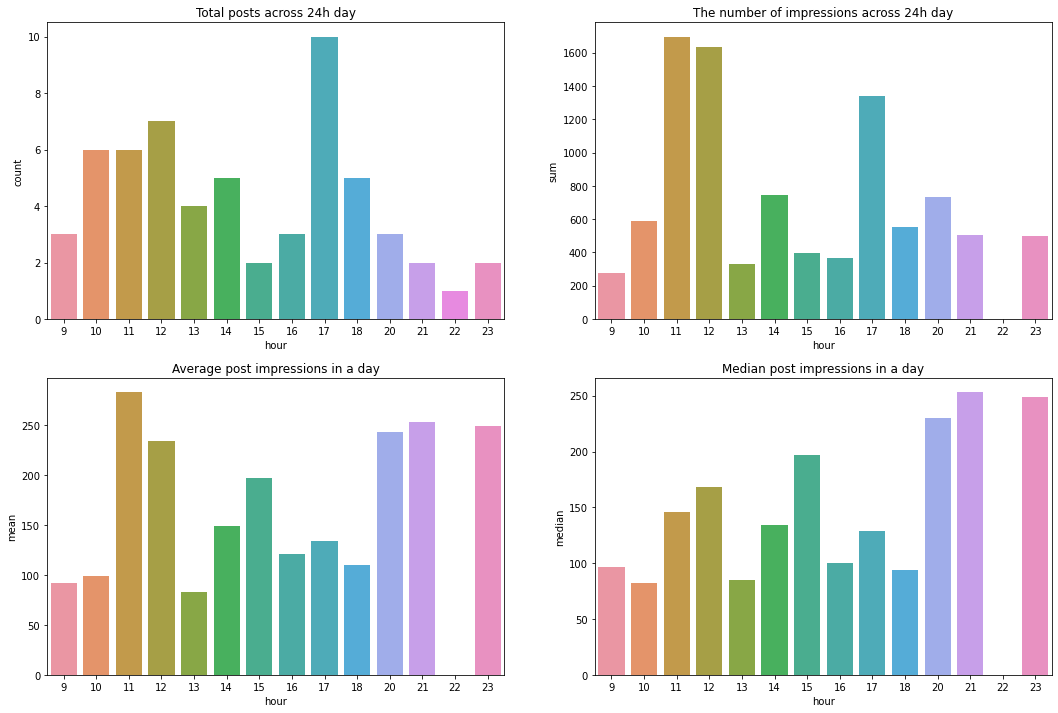

Impression                         
          count   sum        mean median
hour                                    
9             3   275   91.666667   97.0
10            6   591   98.500000   82.0
11            6  1697  282.833333  146.0
12            7  1637  233.857143  168.0
13            4   330   82.500000   85.0
14            5   746  149.200000  134.0
15            2   394  197.000000  197.0
16            3   364  121.333333  100.0
17           10  1343  134.300000  128.5
18            5   552  110.400000   94.0
20            3   731  243.666667  230.0
21            2   506  253.000000  253.0
22            1     0    0.000000    0.0
23            2   498  249.000000  249.0

In [11]:
hour_impression = result.groupby(['hour'])['Impression'].agg(['count','sum','mean','median'])


fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

sns.barplot(x=hour_impression.index, y=hour_impression['count'], ax=axes[0]).set_title("Total posts across 24h day")
plt.ylabel('a')
plt.xticks(rotation=90)

sns.barplot(x=hour_impression.index, y=hour_impression['sum'], ax=axes[1]).set_title("The number of impressions across 24h day")
plt.ylabel('a')
plt.xticks(rotation=90)

sns.barplot(x=hour_impression.index, y=hour_impression['mean'], ax=axes[2]).set_title("Average post impressions in a day")
plt.ylabel('a')
plt.xticks(rotation=90)

sns.barplot(x=hour_impression.index, y=hour_impression['median'], ax=axes[3]).set_title("Median post impressions in a day")
plt.ylabel('median')
plt.xticks(rotation=0)

plt.show()

result.groupby(['hour'])[['Impression']].agg(['count','sum','mean','median'])

### 5.2 Impression Performance over a 7-day week
- The 1st post (Total posts over a week)
    - We have the highest number of posts, 13, on Wednesday, followed by on Monday, Tuesday, and Friday respectively.
    
    
- The 2nd post (Total Impressions over a week)
    - For having the most post numbers on Wednesday (1st graph), thus having the highest total impression, around 2600, is quite reasonable.
    - Notice the impression numbers on both Thursday and Friday is opposite of their total number of posts (1st graph). With only 6 posts on Thursday, it accounts for 1800 impressions, almost equals to the impression figures on Monday and Tuesday, while 10 posts on Friday generates less than 1000 impressions.
    

- The 3rd post (Average Impressions of each post over a week)
    - Following the 2nd post, average post impressions on Thursday is at the highest point, around 284 impressions per post.
    - However, it (Thursday's average post impressions) is not totally a reliable number. Because 1 or more out of 6 posts could be on Holiday or on seasonal period or include particual engaging hashtags, thus creating large quanity of impressions.


- The 4th post (Median Impressions of each post over a week)
    - Following the 3rd post, applying median method to remove some outliers in data.
    - The highest impressions is on Wednesday, followed by Tuesday. Monday, Thursday, Sunday share the third position.
    
    
#### Recommendation
    - Have posts published on Monday, Tuesday, Wednesday, Thursday, and Sunday.
    - Post on wednesday tend to expose to most people, thus being useful for running 'Brand Awareness' campaign.

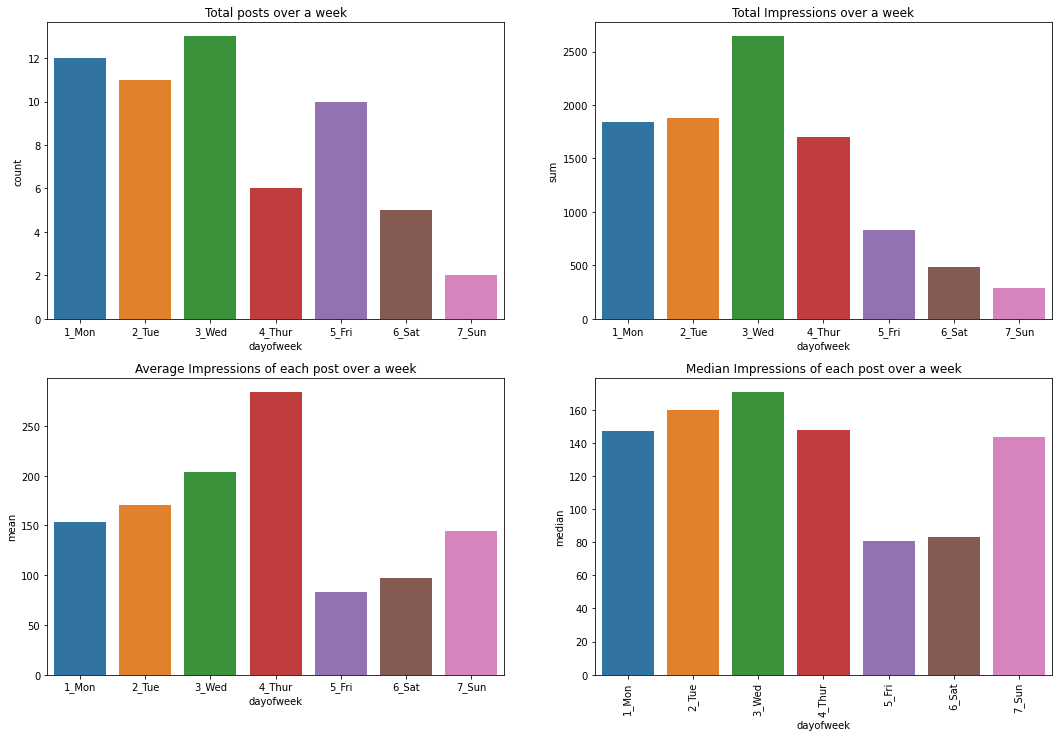

Impression                         
               count   sum        mean median
dayofweek                                    
1_Mon             12  1836  153.000000  147.5
2_Tue             11  1880  170.909091  160.0
3_Wed             13  2642  203.230769  171.0
4_Thur             6  1704  284.000000  148.0
5_Fri             10   830   83.000000   81.0
6_Sat              5   484   96.800000   83.0
7_Sun              2   288  144.000000  144.0

In [12]:
dayofweek_impression = result.groupby(['dayofweek'])['Impression'].agg(['count','sum','mean','median'])


fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

sns.barplot(x=dayofweek_impression.index, y=dayofweek_impression['count'], ax=axes[0]).set_title("Total posts over a week")
plt.ylabel('count')
plt.xticks(rotation=90)

sns.barplot(x=dayofweek_impression.index, y=dayofweek_impression['sum'], ax=axes[1]).set_title("Total Impressions over a week")
plt.ylabel('sum')
plt.xticks(rotation=90)

sns.barplot(x=dayofweek_impression.index, y=dayofweek_impression['mean'], ax=axes[2]).set_title("Average Impressions of each post over a week")
plt.ylabel('mean')
plt.xticks(rotation=90)

sns.barplot(x=dayofweek_impression.index, y=dayofweek_impression['median'], ax=axes[3]).set_title("Median Impressions of each post over a week")
plt.ylabel('median')
plt.xticks(rotation=90)

plt.show()

result.groupby(['dayofweek'])[['Impression']].agg(['count','sum','mean','median'])

### 5.3 Impression Performance over a 12-month year
- The 1st post (Total posts over a year)
    - Having 11 posts in October, the highest number among 12 months.
    - August and September are at the bottom of the list with only 1 post.
    
    
- The 2nd post (Total Impressions over a year)
    - The number of impressions in May is the highest, over 2000, derived from 9 posts (1st graph).


- The 3rd post (Average Impressions of each post over a year)
    - Impression number in September is the highest, derived from 1 post only, thus we can't say a post in Sep performs better than those in other months.


- The 4th post (Median Impressions of each post over a year)
    - Taking a look at 'Nov' and 'Dec' columns in the 3rd graph with those in the 4th graph, they share the same pattern. It means posts in this interval have stable performance, having no outliers.
    - 'Feb', 'May' columns in the 3rd and 4th graph is quite different, meaning outlier happens here. Investigate which posts drived lots of impressions in 'Feb' and 'May' at which time period and if they contained any special hashtags or stories.
    
    
#### Recommendation
    - Looking at a post in Sep and figuring out why we published only 1 post, which performed quite well at this time.
    - Looking for an outlier post in 'Feb', 'May', finding out why they performed well.
    - Having more posts in 'Nov', 'Dec', and less in 'Oct'.

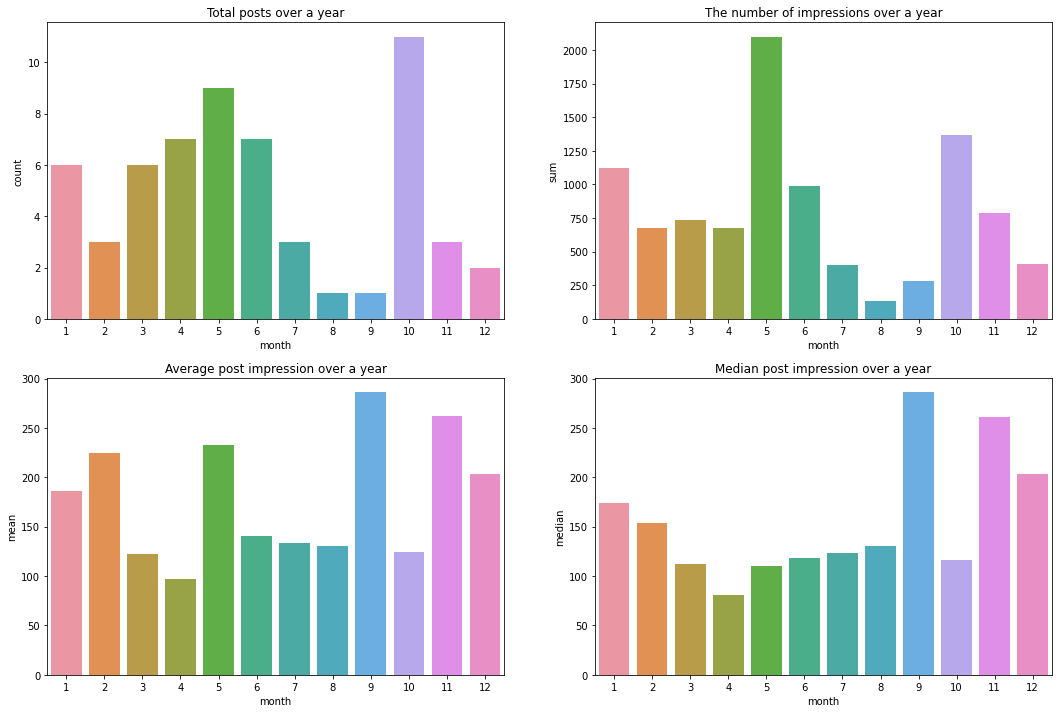

Impression                         
           count   sum        mean median
month                                    
1              6  1119  186.500000  173.5
2              3   675  225.000000  154.0
3              6   735  122.500000  112.5
4              7   676   96.571429   81.0
5              9  2099  233.222222  110.0
6              7   985  140.714286  118.0
7              3   400  133.333333  123.0
8              1   130  130.000000  130.0
9              1   286  286.000000  286.0
10            11  1367  124.272727  116.0
11             3   786  262.000000  261.0
12             2   406  203.000000  203.0

In [13]:
month_impression = result.groupby(['month'])['Impression'].agg(['count','sum','mean','median'])

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

sns.barplot(x=month_impression.index, y=month_impression['count'], ax=axes[0]).set_title("Total posts over a year")
plt.ylabel('count')
plt.xticks(rotation=90)

sns.barplot(x=month_impression.index, y=month_impression['sum'], ax=axes[1]).set_title("The number of impressions over a year")
plt.ylabel('sum')
plt.xticks(rotation=90)

sns.barplot(x=month_impression.index, y=month_impression['mean'], ax=axes[2]).set_title("Average post impression over a year")
plt.ylabel('mean')
plt.xticks(rotation=90)

sns.barplot(x=month_impression.index, y=month_impression['median'], ax=axes[3]).set_title("Median post impression over a year")
plt.ylabel('median')
plt.xticks(rotation=0)

plt.show()

result.groupby(['month'])[['Impression']].agg(['count','sum','mean','median'])

## 6. Engagement Performance of dayweek

### 6.1 Engagement Performance over a 24h day
- The 1st post (Total posts across a 24h day)
    - Having mentioned above, we mostly published at 17 o'clock.
   
   
- The 2nd post (The number of engagement across a 24h day)
    - Around 12 o'clock get most users engagement, around 140 interactions from 7 posts.
    - Having a lots of posts at 17 o'clock acquires only 70 engagements in total.
    
    
- The 3rd post (Average post engagement in a day)
    - On average, posts at 12, 16, 20, 21, 23 o'clock received above 15 engagements.
    - *Precautious of outliers*.
    
    
- The 4th post (Median post engagement in a day)
    - Looking at 12, 16 o'clock on both 3rd and 4th graph shows outliers occur here. Some posts in these times outperformed the average.
    - Whereas, posts at 20, 21, 23 are quite similar in pattern and at the top in term of engagement.
    
    
#### Recommendation
    - 17 o'clock is not really an ideal time for posts.
    - Focus on the posts published at 12, 20, 21, 22, 23 o'clock.

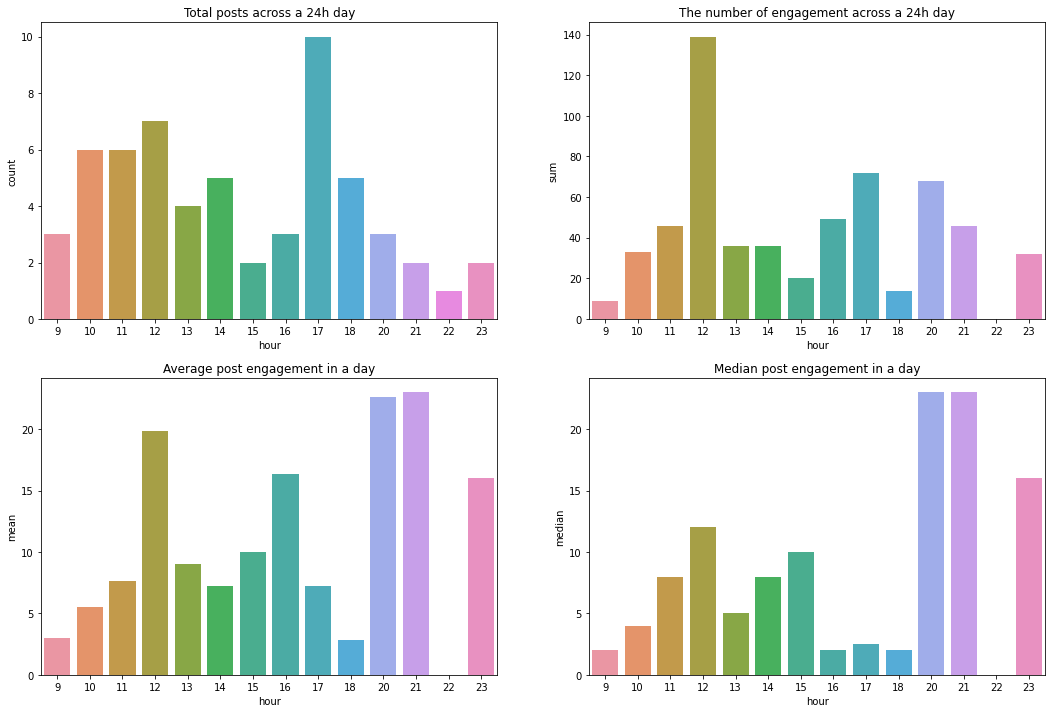

engagement                       
          count  sum       mean median
hour                                  
9             3    9   3.000000    2.0
10            6   33   5.500000    4.0
11            6   46   7.666667    8.0
12            7  139  19.857143   12.0
13            4   36   9.000000    5.0
14            5   36   7.200000    8.0
15            2   20  10.000000   10.0
16            3   49  16.333333    2.0
17           10   72   7.200000    2.5
18            5   14   2.800000    2.0
20            3   68  22.666667   23.0
21            2   46  23.000000   23.0
22            1    0   0.000000    0.0
23            2   32  16.000000   16.0

In [14]:
hour_engagement = result.groupby(['hour'])['engagement'].agg(['count','sum','mean','median'])


fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

sns.barplot(x=hour_engagement.index, y=hour_engagement['count'], ax=axes[0]).set_title("Total posts across a 24h day")
plt.ylabel('count')
plt.xticks(rotation=90)

sns.barplot(x=hour_engagement.index, y=hour_engagement['sum'], ax=axes[1]).set_title("The number of engagement across a 24h day")
plt.ylabel('sum')
plt.xticks(rotation=90)

sns.barplot(x=hour_engagement.index, y=hour_engagement['mean'], ax=axes[2]).set_title("Average post engagement in a day")
plt.ylabel('mean')
plt.xticks(rotation=90)

sns.barplot(x=hour_engagement.index, y=hour_engagement['median'], ax=axes[3]).set_title("Median post engagement in a day")
plt.ylabel('median')
plt.xticks(rotation=0)
plt.show()


result.groupby(['hour'])[['engagement']].agg(['count','sum','mean','median'])

### 6.2 Engagement Performance over a 7day week
- The 1st post (Total posts over a week)
    - Having mentioned above, we have most posts on Wednesday.
   
   
- The 2nd post (Total Engagement over a week)
    - Most total engagement figures are in the descending order Wednesday, Tuesday, Monday.
    
    
- The 3rd post (Average Engagement of each post over a week)
    - On average, Wednesday' posts indicate the best performance of engagement.
    - *Precautious of outliers*.
    
    
- The 4th post (Median Engagement of each post over a week)
    - Removing outliers by applying median method shows Tuesday's posts are the best engagement.
    - While, Monday, Wednesday, Thursday, Sunday do not differ to each other.
    
    
#### Recommendation
    - The 4th graph shows Monday and Wednesday contains outliers, deducing that if we want to make a huge breaking ground of engagement, we consider posts on Monday and Wednesday.
    - Overall, Monday, Tuesday, Wednesday, and Sunday are fine day if we focus on engagement metric.
    - Avoid Friday, and Saturday.

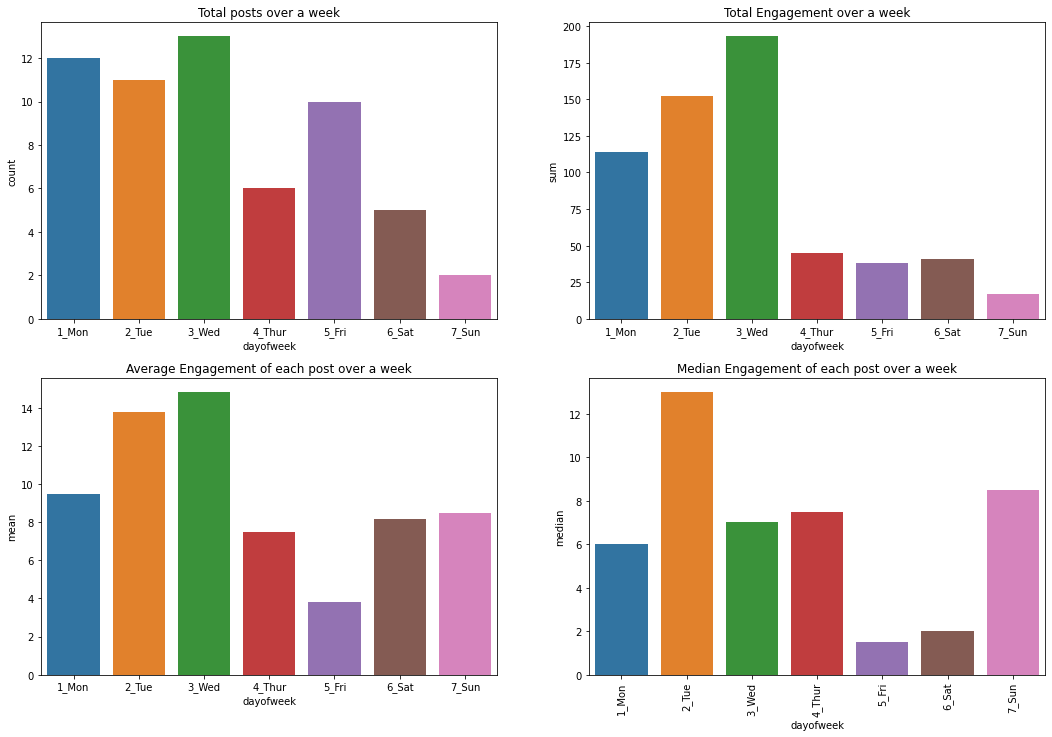

engagement                       
               count  sum       mean median
dayofweek                                  
1_Mon             12  114   9.500000    6.0
2_Tue             11  152  13.818182   13.0
3_Wed             13  193  14.846154    7.0
4_Thur             6   45   7.500000    7.5
5_Fri             10   38   3.800000    1.5
6_Sat              5   41   8.200000    2.0
7_Sun              2   17   8.500000    8.5

In [15]:
dayofweek_engagement = result.groupby(['dayofweek'])['engagement'].agg(['count','sum','mean','median'])


fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

sns.barplot(x=dayofweek_engagement.index, y=dayofweek_engagement['count'], ax=axes[0]).set_title("Total posts over a week")
plt.ylabel('count')
plt.xticks(rotation=90)

sns.barplot(x=dayofweek_engagement.index, y=dayofweek_engagement['sum'], ax=axes[1]).set_title("Total Engagement over a week")
plt.ylabel('sum')
plt.xticks(rotation=90)

sns.barplot(x=dayofweek_engagement.index, y=dayofweek_engagement['mean'], ax=axes[2]).set_title("Average Engagement of each post over a week")
plt.ylabel('mean')
plt.xticks(rotation=90)

sns.barplot(x=dayofweek_engagement.index, y=dayofweek_engagement['median'], ax=axes[3]).set_title("Median Engagement of each post over a week")
plt.ylabel('median')
plt.xticks(rotation=90)

plt.show()

result.groupby(['dayofweek'])[['engagement']].agg(['count','sum','mean','median'])

### 6.3 Engagement Performance over a 12month year


- The 1st post (Total posts over a year)
    - Having mentioned above, we have most posts in 'Oct'.
   
   
- The 2nd post (Total Engagement over a year)
    - Most total engagement numbers fall in 'Jan', 'Otc'.
    
    
- The 3rd post (Average Engagement of each post over a year)
    - On average, 'Oct', 'Nov', 'Dec', 'Jan' involves much engagement, derived from at least 2 posts in each months.
    - 'Sep' 's post has quite good engagement, the figure is derived from only 1 post. Thus can't really say about 'Sep'.
    - *Precautious of outliers.*
    
    
- The 4th post (Median Engagement of each post over a year)
    - Removing outliers by applying median method shows 'Nov', 'Dec', 'Jan' are the best engagement.
    - While, in the middle of a year people are less likely to engage with our posts.
    
    
#### Recommendation
    - Towards to the year end, and the beginning of new year, we should have more posts on our social media.

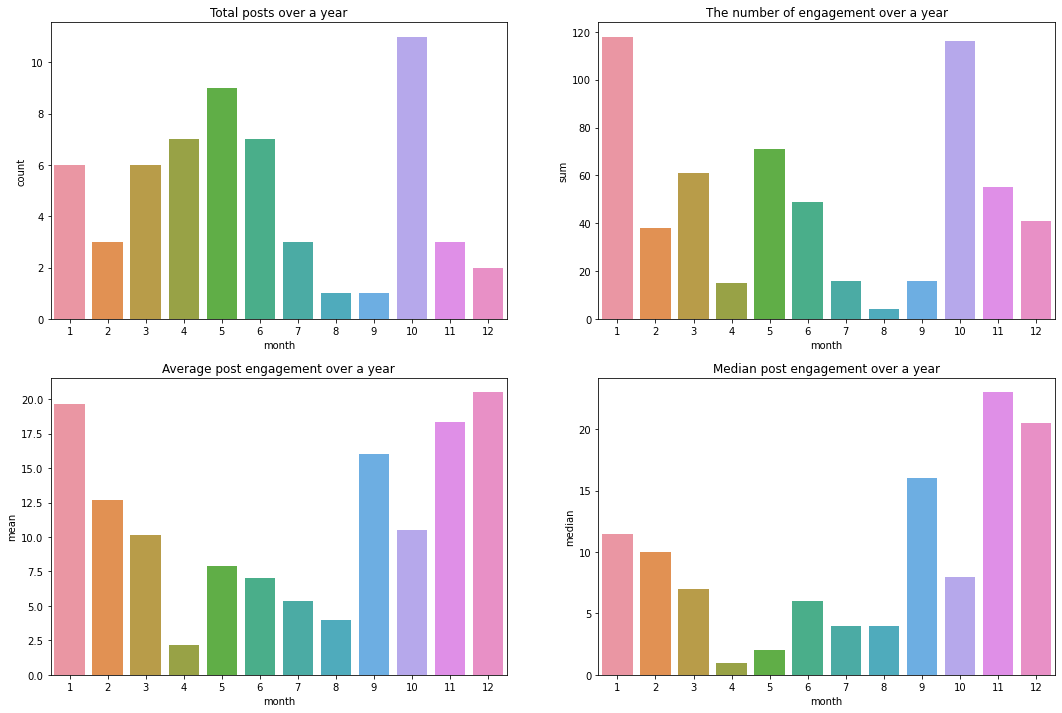

engagement                       
           count  sum       mean median
month                                  
1              6  118  19.666667   11.5
2              3   38  12.666667   10.0
3              6   61  10.166667    7.0
4              7   15   2.142857    1.0
5              9   71   7.888889    2.0
6              7   49   7.000000    6.0
7              3   16   5.333333    4.0
8              1    4   4.000000    4.0
9              1   16  16.000000   16.0
10            11  116  10.545455    8.0
11             3   55  18.333333   23.0
12             2   41  20.500000   20.5

In [16]:
month_engagement = result.groupby(['month'])['engagement'].agg(['count','sum','mean','median'])

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

sns.barplot(x=month_engagement.index, y=month_engagement['count'], ax=axes[0]).set_title("Total posts over a year")
plt.ylabel('count')
plt.xticks(rotation=90)

sns.barplot(x=month_engagement.index, y=month_engagement['sum'], ax=axes[1]).set_title("The number of engagement over a year")
plt.ylabel('sum')
plt.xticks(rotation=90)

sns.barplot(x=month_engagement.index, y=month_engagement['mean'], ax=axes[2]).set_title("Average post engagement over a year")
plt.ylabel('mean')
plt.xticks(rotation=90)

sns.barplot(x=month_engagement.index, y=month_engagement['median'], ax=axes[3]).set_title("Median post engagement over a year")
plt.ylabel('median')
plt.xticks(rotation=0)

plt.show()

result.groupby(['month'])[['engagement']].agg(['count','sum','mean','median'])

## 7. Impression vs Engagement

- The graph below show the relationship between Impression and Engagement. More impressions tend to get more engagement.
- On the right half of the graph shows the some posts with the best performance, most of which are on Wednesday, Tuesday, Monday.

In [17]:
# Remove outliers in dataset
result.drop(result[result['Impression'] == 0].index, inplace=True)

# Transforming data
result['impression_log'] = np.log1p(result["Impression"])
result['engagement_log'] = np.log1p(result["engagement"])

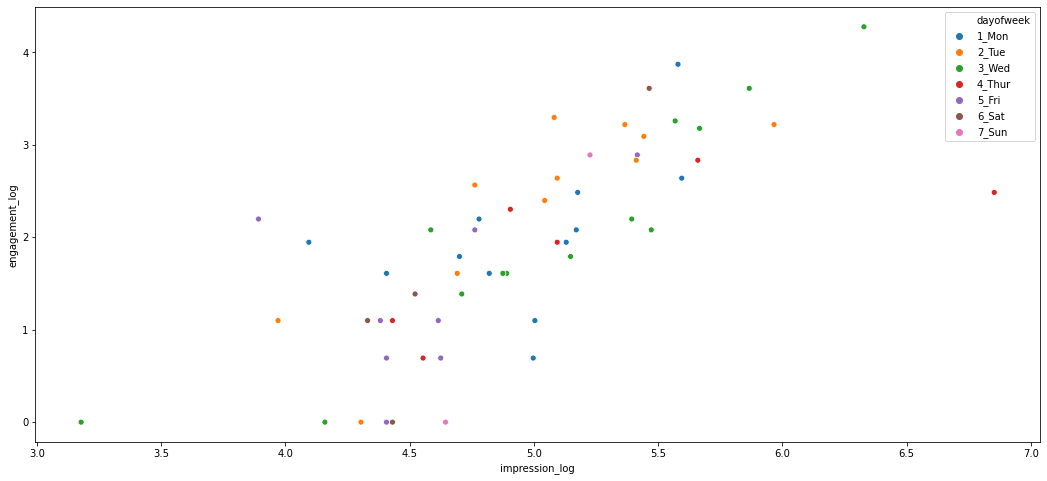

In [18]:
hue_order = ['1_Mon','2_Tue','3_Wed','4_Thur','5_Fri','6_Sat','7_Sun']

fig = plt.figure(figsize=(18, 8))
sns.scatterplot(data=result, x="impression_log", y="engagement_log", hue='dayofweek', hue_order=hue_order, sizes=80)

plt.show()

## 8. Correlation between Reach, Impression, Engagement, Life time of each post

- The graph shows Reach and Impression are closely correlated.
- Engagement is higher if a post get higher Reach and/or Impression. 
- Life time of a post is mostly correlated with engagement, meaning if a post is older, it tends to get higher engagement.

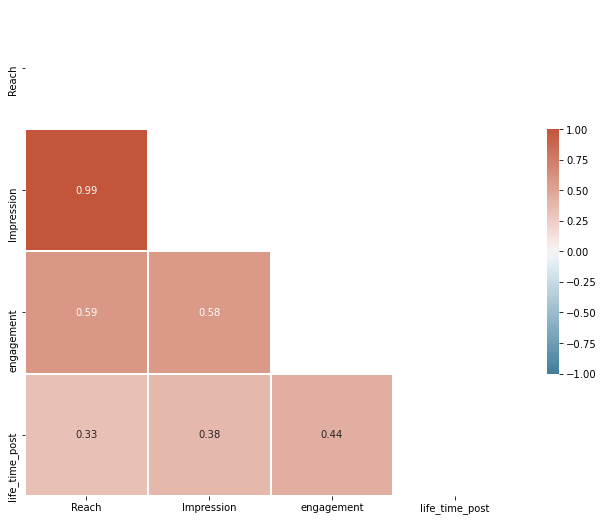

In [19]:
result['life_time_post'] = (pd.to_datetime('today').date() - result['date']).astype('timedelta64[D]')

columns = ['Reach', 'Impression', 'engagement','life_time_post']

# Compute the correlation matrix
corr = result[columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin = -1, vmax = 1,
            linewidths=1, cbar_kws={"shrink": 0.5}, annot=True)

plt.show()

## 9. Further Analysis
- Tracking keywords, phrases, hashtags mostly used
- How often we post?
- When was the last time we posted?
- Do we respond to comments?
- Types of content: text, image, video